In [22]:
import numpy as np
class MEWOA:
    """多种群进化的鲸鱼优化算法 (MEWOA) Multiple Population Whale Optimization Algorithm"""
    def __init__(self, func, dim, bounds, max_iter, population_size=30):
        """
        :param func: 目标函数
        :param dim: 维度
        :param bounds: (lower_bound, upper_bound)
        :param max_iter: 最大迭代次数
        :param population_size: 种群大小
        """
        self.func = func
        self.dim = dim
        self.lb, self.ub = bounds
        self.max_iter = max_iter
        self.population_size = population_size

        # 初始化种群
        self.population = self.initialize_population()
        
        # 最优解和最优适应度
        self.best_solution = None
        self.best_fitness = float('inf')
        
        # 更新初始最优解
        self.update_best()
        
    def initialize_population(self):
        """初始化种群"""
        population = np.random.uniform(self.lb, self.ub, (self.population_size, self.dim))
        return population
    
    def fitness(self, solution:np.ndarray) -> float:
        """计算适应度"""
        return self.func(solution)
    
    def update_best(self):
        """更新最优解"""
        for i in range(self.population_size):
            fitness = self.fitness(self.population[i])
            if fitness < self.best_fitness:
                self.best_fitness = fitness
                self.best_solution = self.population[i].copy()
    
    def boundary_check(self, solution:np.ndarray) -> np.ndarray:
        """边界检查"""
        return np.clip(solution, self.lb, self.ub)
    
    def sort_population_by_fitness(self):
        """按升序适应度排序种群"""
        fitness_values = np.array([self.fitness(ind) for ind in self.population])
        sorted_indices = np.argsort(fitness_values)
        sorted_population = self.population[sorted_indices]
        sorted_fitness = fitness_values[sorted_indices]
        return sorted_population, sorted_fitness
    
    # 三个子种群的“位置更新”操作
    def update_exploration(self, whale:np.ndarray, leader_pos:np.ndarray, a:int, w=1.0) -> np.ndarray:
        """更新探索种群的位置,为了全局搜索,使用随机选择的鲸鱼"""
        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)
        A = 2.0 * a * r1 - a
        C = 2.0 * r2
    
        position = whale.copy()    
        rand_index = np.random.randint(self.population_size)
        X_rand = self.population[rand_index]
        D_rand = np.abs(C * X_rand - position)
        new_position = X_rand - A * D_rand
        
        # 边界检查
        new_position = self.boundary_check(new_position)
        return new_position
    
    def update_exploitation(self, whale:np.ndarray, leader_pos:np.ndarray, a:int, w=1.0):
        """"更新开发种群的位置,为了局部搜索,使用当前最优解"""
        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)
        A = 2.0 * a * r1 - a
        C = 2.0 * r2
        b = 1.0
        l = 2.0 * np.random.rand(self.dim) - 1.0
        p = np.random.rand()

        new_pos = whale.copy()
        if p >= 0.5:
            # 螺旋
            distance2Leader = np.abs(leader_pos - whale)
            new_pos = distance2Leader * np.exp(b * l) * np.cos(2.0 * np.pi * l) + w * leader_pos
        else:
            # 收缩包围
            D_leader = np.abs(C * leader_pos - whale)
            new_pos = w * leader_pos - A * D_leader

        # 边界检查
        new_pos = self.boundary_check(new_pos)
        return new_pos
    
    def update_modest(self, whale:np.ndarray, leader_pos:np.ndarray, a:int, w=1.0):
        """Modest种群更新,包含螺旋更新与收缩包围、以及类似探索的更新组合"""
        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)
        A = 2.0 * a * r1 - a
        C = 2.0 * r2
        b = 1.0
        l = 2.0 * np.random.rand(self.dim) - 1.0
        p = np.random.rand()

        new_pos = whale.copy()
        if p >= 0.5:
            # 进一步分支
            p1 = np.random.rand()
            if p1 >= 0.5:
                # 螺旋
                distance2Leader = np.abs(leader_pos - whale)
                new_pos = distance2Leader * np.exp(b * l) * np.cos(2.0 * np.pi * l) + w * leader_pos
            else:
                # 收缩包围
                D_leader = np.abs(C * leader_pos - whale)
                new_pos = w * leader_pos - A * D_leader
        else:
            # 类似搜索阶段
            rand_index = np.random.randint(self.population_size)
            X_rand = self.population[rand_index]
            D_X_rand = np.abs(C * X_rand - whale)
            new_pos = w * X_rand - A * D_X_rand

        # 边界检查
        new_pos = self.boundary_check(new_pos)
        return new_pos
        
    # 三个子种群的“进化”操作
    def evolve_exploration(self, whale:np.ndarray) -> np.ndarray:
        """探索种群的进化"""
        r = 1.0 + np.random.rand(self.dim)
        new_pos = whale * r

        new_pos = self.boundary_check(new_pos)
        return new_pos
    
    def evolve_exploitation(self, whale:np.ndarray):
        """开发种群的进化"""
        r = 2.0 * np.random.rand(self.dim)
        new_pos = self.best_solution * r

        new_pos = self.boundary_check(new_pos)
        return new_pos
    
    def evolve_modest(self, whale:np.ndarray):
        """Modest种群的进化,使用对称映射思想(opposite-based learning)"""
        opposite_pos = (self.ub + self.lb) - whale
        opposite_pos = self.boundary_check(opposite_pos)
        # 如果对称位置更好，则替换；否则保持原位置
        return opposite_pos
    
    def population_evolution(self, sorted_pop):
        """
        对三个子种群分别执行种群演化。
        sub_pop1(Exploitative): 前 1/3
        sub_pop2(Modest): 中 1/3
        sub_pop3(Exploratory): 后 1/3
        """
        index = self.population_size // 3

        # exploitative: 前 index 个
        for i in range(0, index):
            new_pos = self.evolve_exploitation(sorted_pop[i])
            # 比较新旧适应度，保留更优
            if self.fitness(new_pos) < self.fitness(sorted_pop[i]):
                sorted_pop[i] = new_pos

        # modest: 中间 index 个
        for i in range(index, 2 * index):
            new_pos = self.evolve_modest(sorted_pop[i])
            if self.fitness(new_pos) < self.fitness(sorted_pop[i]):
                sorted_pop[i] = new_pos

        # exploratory: 后面 (包含余数)
        for i in range(2 * index, self.population_size):
            new_pos = self.evolve_exploration(sorted_pop[i])
            if self.fitness(new_pos) < self.fitness(sorted_pop[i]):
                sorted_pop[i] = new_pos

        return sorted_pop
    
    def run(self):
        for iteration in range(self.max_iter):
            # 计算 a (线性递减)
            a = 2.0 * (self.max_iter - iteration) / self.max_iter
            w = 1.0

            # 先对种群按适应度排序，以便分配到三个子种群
            sorted_pop, sorted_fit = self.sort_population_by_fitness()
            # 更新全局最优
            if sorted_fit[0] < self.best_fitness:
                self.best_fitness = sorted_fit[0]
                self.best_solution = sorted_pop[0].copy()

            if (iteration + 1) % 2 == 0:
                # 偶数代 -> 种群演化
                evolved_pop = self.population_evolution(sorted_pop)
                self.population = evolved_pop
            else:
                # 奇数代 -> 位置更新
                index = self.population_size // 3
                # exploitative
                for i in range(0, index):
                    self.population[i] = self.update_exploitation(
                        sorted_pop[i], self.best_solution, a, w
                    )
                # modest
                for i in range(index, 2 * index):
                    self.population[i] = self.update_modest(
                        sorted_pop[i], self.best_solution, a, w
                    )
                # exploratory
                for i in range(2 * index, self.population_size):
                    self.population[i] = self.update_exploration(
                        sorted_pop[i], self.best_solution, a, w
                    )

            # 全局最优解更新
            self.update_best()

        return self.best_solution, self.best_fitness
    

Sphere函数最优解: [ 1.98221563e-08  8.42879912e-11 -1.24595144e-08 -4.21258095e-10
 -1.72646127e-10 -7.10171171e-09 -3.09923266e-11  6.51403172e-11
 -1.01504854e-08  4.94752871e-11  5.07631986e-09  1.67677067e-09
  7.29844056e-11  4.83575553e-11  5.95109056e-10  5.03491587e-11
  6.15725194e-10  2.58016263e-08 -3.60965672e-08  1.77435677e-12
  3.88855765e-08 -2.16732197e-09  3.39472108e-09  5.56857858e-10
 -4.95597442e-09  7.47553177e-10 -2.72007754e-10  3.42126250e-10
 -2.66751291e-10 -1.17640423e-08]
Sphere函数最优值: 4.39225117720426e-15
Rastrigin函数最优解: [-4.70812772e-04  5.81171063e-02 -6.60866578e-02  2.52424238e-02
  6.53886356e-03  1.00306834e-05 -2.46355184e-03  7.50020599e-03
 -1.02346930e+00 -5.90109770e-02 -1.03477995e+00  6.77636310e-04
  3.66035706e-04 -1.97927712e+00  2.93252461e-03 -1.46032855e-01
 -3.12669741e-03  1.01917751e+00  4.81951334e-03  1.99918881e+00
  5.76799397e-03 -1.12901503e-02 -7.14809134e-03 -8.88582316e-05
  1.05699367e-02  9.51775404e-01 -1.04674994e-02  5.962764

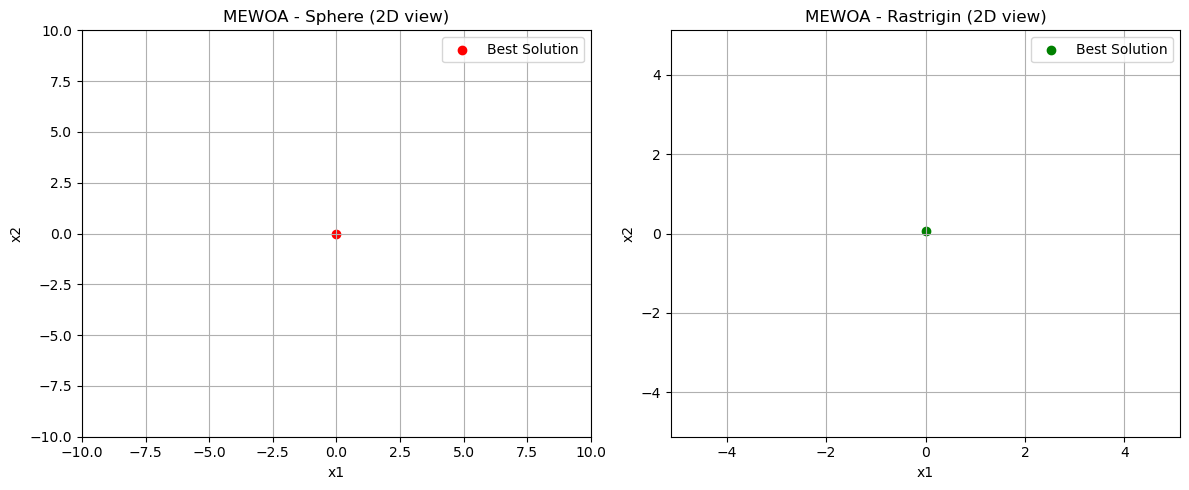

In [24]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
    def sphere(x):
        return np.sum(x**2)

    def rastrigin(x):
        n = len(x)
        A = 10
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

    dim = 30
    bounds = (-10, 10)
    max_iter = 100
    population_size = 30

    mewoa_sphere = MEWOA(func=sphere, dim=dim, bounds=bounds,
                         max_iter=max_iter, population_size=population_size)
    best_sol_sphere, best_fit_sphere = mewoa_sphere.run()
    print("Sphere函数最优解:", best_sol_sphere)
    print("Sphere函数最优值:", best_fit_sphere)

    mewoa_rastrigin = MEWOA(func=rastrigin, dim=dim, bounds=(-5.12, 5.12),
                            max_iter=max_iter, population_size=population_size)
    best_sol_ras, best_fit_ras = mewoa_rastrigin.run()
    print("Rastrigin函数最优解:", best_sol_ras)
    print("Rastrigin函数最优值:", best_fit_ras)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("MEWOA - Sphere (2D view)")
    plt.scatter(best_sol_sphere[0], best_sol_sphere[1], color='r', label='Best Solution')
    plt.xlim(bounds[0], bounds[1])
    plt.ylim(bounds[0], bounds[1])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("MEWOA - Rastrigin (2D view)")
    plt.scatter(best_sol_ras[0], best_sol_ras[1], color='g', label='Best Solution')
    plt.xlim(-5.12, 5.12)
    plt.ylim(-5.12, 5.12)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()